## **Imports**

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Load Book image**

Image Dimensions: 
(440, 350, 3)


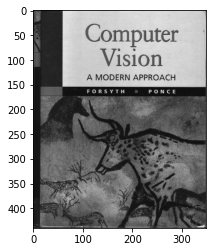

In [ ]:
cv_cover_img = cv2.imread("/content/cv_cover.jpg")
print("Image Dimensions: ")
print(cv_cover_img.shape)
plt.imshow(cv_cover_img)

## **Function to load video frames**

In [ ]:
def loadVid(path):
    # Create a VideoCapture object and read from input file
    # If the input is the camera, pass 0 instead of the video file name
    cap = cv2.VideoCapture(path)
     
    # Check if camera opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")

    i = 0
    # Read until video is completed
    while(cap.isOpened()):
        # print("alo")
        # Capture frame-by-frame
        i += 1
        ret, frame = cap.read()
        if ret == True:

            #Store the resulting frame
            if i == 1:
                frames = frame[np.newaxis, ...]
            else:
                frame = frame[np.newaxis, ...]
                frames = np.vstack([frames, frame])
                frames = np.squeeze(frames)
            
        else: 
            break
     
    # When everything done, release the video capture object
    cap.release()

    return frames

## **Load 2 videos**

In [ ]:
book_video = loadVid("/content/drive/MyDrive/book.mov")
print('Number of video frames:')
print(book_video.shape[0])

Number of video frames:
641


Each frame Dimensions: 
(480, 640)


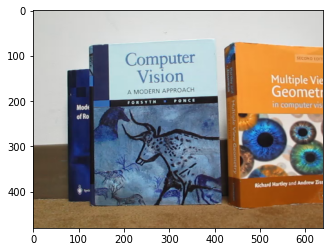

In [ ]:
print("Each frame Dimensions: ")
print(book_video.shape[1:3])
plt.imshow(book_video[0])

In [ ]:
ar_video = loadVid("/content/drive/MyDrive/ar_source.mov")
print('Number of video frames:')
print(ar_video.shape[0])

Number of video frames:
511


Each frame Dimensions: 
(360, 640)


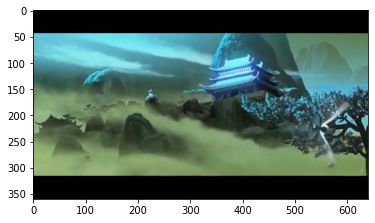

In [ ]:
print("Each frame Dimensions: ")
print(ar_video.shape[1:3])
plt.imshow(ar_video[0])

## **1.1 Getting Correspondences**

In [ ]:
def get_correspondences(img1,img2,k=50):
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
  keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
  #feature matching
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)

  good = []
  for m,n in matches:
      if m.distance / n.distance  < 0.65:
          good.append([m.distance / n.distance,m])

  matches = sorted(good)[:k]
  good_matches = []
  for i in matches:
    good_matches.append(i[1])
    
  return keypoints_1,keypoints_2,good_matches

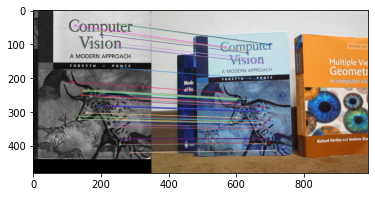

(<matplotlib.image.AxesImage at 0x7f890b256a10>, None)

In [ ]:
keypoints_1, keypoints_2, matches = get_correspondences(cv_cover_img, book_video[0], 50)
matched_points = cv2.drawMatches(cv_cover_img, keypoints_1, book_video[0], keypoints_2, matches, book_video[0], flags=2)
plt.imshow(matched_points),plt.show()

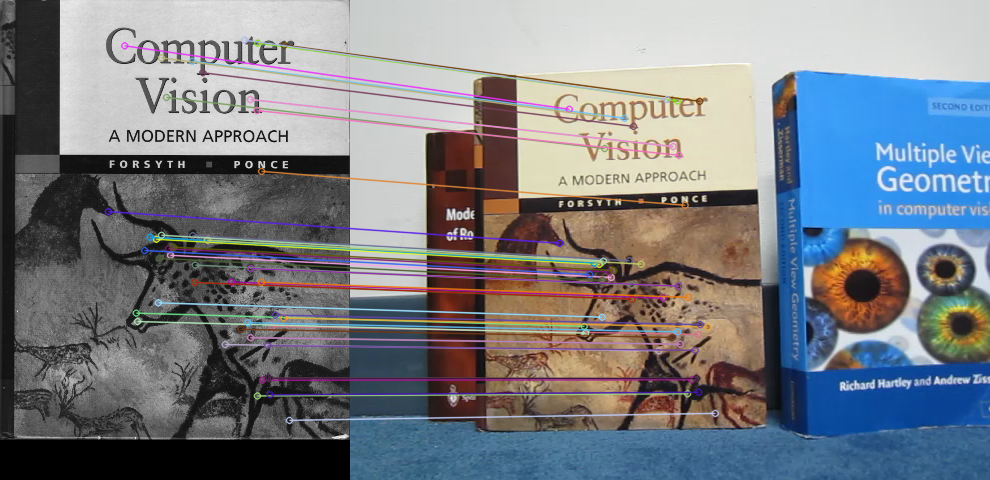

In [ ]:
cv2_imshow(matched_points)

## **1.2 Compute the Homography Parameters**

In [ ]:
correspondenceList = []
points_1 = []
points_2 = []
for match in matches:
    (x1, y1) = keypoints_1[match.queryIdx].pt
    (x2, y2) = keypoints_2[match.trainIdx].pt
    points_1.append([x1,y1])
    points_2.append([x2,y2])
    correspondenceList.append([x1, y1, x2, y2])

In [ ]:
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.array(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    
    return h

In [ ]:
correspondenceList = np.array(correspondenceList)

In [ ]:
H = calculateHomography(correspondenceList)

In [ ]:
print(H)

[[ 7.73778320e-01  3.30955593e-03  1.19459841e+02]
 [-5.23431672e-02  7.78790167e-01  7.79037372e+01]
 [-9.05627058e-05 -7.40099003e-05  1.00000000e+00]]


In [ ]:
x = cv2.findHomography(np.array(points_1),np.array(points_2),cv2.RANSAC)
print(x[0])

[[ 7.74999682e-01  3.44772870e-03  1.19349922e+02]
 [-5.16607084e-02  7.79409929e-01  7.77740349e+01]
 [-8.81834885e-05 -7.36163252e-05  1.00000000e+00]]


In [ ]:
def apply_homography(H,p):
  p = np.array([p[0],p[1],1])
  p_new = np.dot(H,p)
  x_new = round(p_new[0] / p_new[2])
  y_new = round(p_new[1] / p_new[2])
  return [x_new,y_new]

In [ ]:
def test_point(p,img1,img2,H):
  im1 = img1.copy()
  im2 = img2.copy()
  im1 = cv2.circle(im1,(p[0],p[1]), 5, (0,255,0), 4)
  p_new = apply_homography(H,p)
  im2 = cv2.circle(im2,(int(p_new[0]),int(p_new[1])), 5, (0,255,0), 4)
  fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(8,6))
  ax[0].imshow(im1)
  ax[1].imshow(im2)
  plt.imshow(im1)
  plt.imshow(im2)

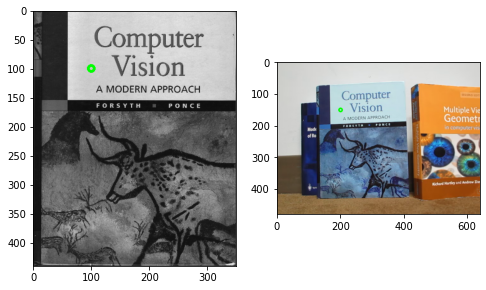

In [ ]:
test_point([100,100], cv_cover_img, book_video[0], H)

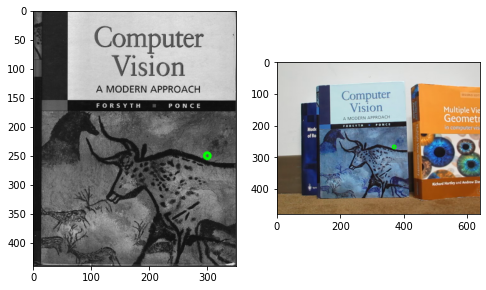

In [ ]:
test_point([300,250], cv_cover_img, book_video[0], H)

## **1.3 Calculate Book Coordinates**

In [ ]:
def get_corners(img,H):
  Width,Length,_ = img.shape

  top_left = apply_homography(H,[0,0])
  top_right = apply_homography(H,[0,Width])
  bot_left = apply_homography(H,[Length,0])
  bot_right = apply_homography(H,[Length,Width])
  return top_left,top_right ,bot_left,bot_right

In [ ]:
tl,tr,bl,br = get_corners(cv_cover_img,H)

In [ ]:
def display_corners(image,top_left,top_right,bot_left,bot_right):
  image = cv2.circle(image,(top_left[0],top_left[1]), 5, (0,255,0), 4)
  image = cv2.circle(image,(top_right[0],top_right[1]), 5, (0,255,0), 4)
  image = cv2.circle(image,(bot_left[0],bot_left[1]), 5, (0,255,0), 4)
  image = cv2.circle(image,(bot_right[0],bot_right[1]), 5, (0,255,0), 4)
  plt.imshow(image)

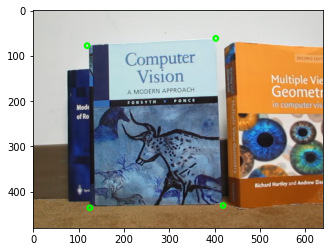

In [ ]:
img_copy = book_video[0].copy()
display_corners(img_copy,tl,tr,bl,br)

In [ ]:
print(tl,tr,bl,br)

[119, 78] [125, 435] [403, 62] [419, 430]


## **1.4 Crop AR Video Frames**

image dimensions:
(440, 350, 3)
aspect ratio:
0.7954545454545454


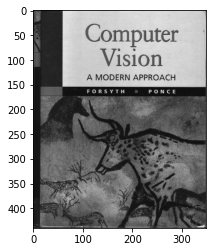

In [ ]:
plt.imshow(cv_cover_img)
cv_cover_aspectRatio = cv_cover_img.shape[1] / cv_cover_img.shape[0]
print('image dimensions:')
print(cv_cover_img.shape)
print('aspect ratio:')
print(cv_cover_aspectRatio)

(360, 640, 3)


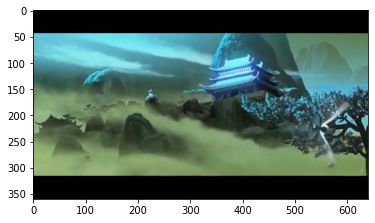

In [ ]:
plt.imshow(ar_video[0])
print(ar_video[0].shape)

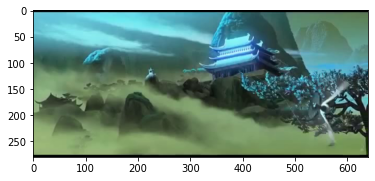

In [ ]:
ar_video_temp = ar_video[0][40:320].copy()
plt.imshow(ar_video_temp)

In [ ]:
y_frame_centre = ar_video_temp.shape[1]/2
print(y_frame_centre)

320.0


In [ ]:
## width of the new cropped frame
new_width = ar_video_temp.shape[0] * cv_cover_img.shape[1] // cv_cover_img.shape[0]
print('new width for ar video frames:')
print(new_width)

new width for ar video frames:
222


In [ ]:
indices_cropped = [int(y_frame_centre - new_width/2), int(y_frame_centre + new_width/2)]
print('Indices used to crop frame to be the same aspect ration of cv cover image:')
print(indices_cropped)

Indices used to crop frame to be the same aspect ration of cv cover image:
[209, 431]


In [ ]:
x = ar_video_temp[:, indices_cropped[0]:indices_cropped[1]]

In [ ]:
x.shape

(280, 222, 3)

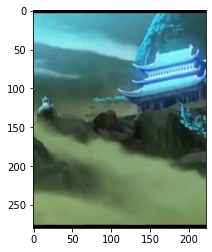

In [ ]:
plt.imshow(x)

In [ ]:
new_x = cv2.resize(x, (cv_cover_img.shape[1], cv_cover_img.shape[0]))

In [ ]:
new_x.shape

(440, 350, 3)

## **1.5 Overlay the First Frame of the Two Videos**

In [ ]:
y = book_video[0].copy()

In [ ]:
y.shape

(480, 640, 3)

In [ ]:
Width,Length,_ = new_x.shape
for i in range(Length):
  for j in range(Width):
    p_new = apply_homography(H,[i,j])
    if p_new[1]>0 and p_new[1]<480 and p_new[0]>0 and p_new[0]<640:
      y[p_new[1],p_new[0]] = new_x[j][i]

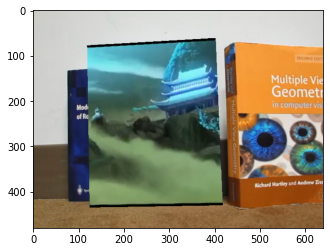

In [ ]:
plt.imshow(y)

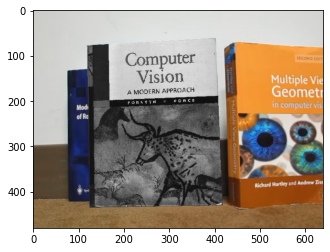

In [ ]:
y = book_video[0].copy()
Width,Length,_ = cv_cover_img.shape
for i in range(Length):
  for j in range(Width):
    p_new = apply_homography(H,[i,j])
    if p_new[1]>0 and p_new[1]<480 and p_new[0]>0 and p_new[0]<640:
      y[p_new[1],p_new[0]] = cv_cover_img[j][i]
plt.imshow(y)

## **1.6 Creating AR Application**

In [ ]:
def create_new_frame(cv_cover_img, ar_frame, book_frame):
  des_frame = book_frame.copy()
  keypoints_1, keypoints_2, matches = get_correspondences(cv_cover_img, des_frame, 50)

  correspondenceList = []
  points_1 = []
  points_2 = []
  for match in matches:
      (x1, y1) = keypoints_1[match.queryIdx].pt
      (x2, y2) = keypoints_2[match.trainIdx].pt
      points_1.append([x1,y1])
      points_2.append([x2,y2])
      correspondenceList.append([x1, y1, x2, y2])
  correspondenceList = np.array(correspondenceList)
  H = calculateHomography(correspondenceList)

  res_frame = ar_frame[40:320].copy()
  x = res_frame[:, indices_cropped[0]:indices_cropped[1]]
  new_x = cv2.resize(x, (cv_cover_img.shape[1], cv_cover_img.shape[0]))
  Width,Length,_ = new_x.shape
  for i in range(Length):
    for j in range(Width):
      p_new = apply_homography(H,[i,j])
      if p_new[1]>0 and p_new[1]<480 and p_new[0]>0 and p_new[0]<640:
        des_frame[p_new[1],p_new[0]] = new_x[j][i]
  # plt.imshow(des_frame)
  return des_frame

In [ ]:
output_frames = []
for i in range(ar_video.shape[0]):
  output_frames.append(create_new_frame(cv_cover_img, ar_video[i], book_video[i]))

In [ ]:
for i in range(output_frames.shape[0]):
  cv2_imshow(output_frames[i])

In [ ]:
for i in range(output_frames.shape[0]):
  cv2.imwrite(f'/content/drive/MyDrive/output frames/{i}.png',output_frames[i])

In [ ]:
import os 
from os.path import isfile, join 
def convert_pictures_to_video(output_frames, pathIn, pathOut, fps, time):
    height, width, layers = output_frames[0].shape
    size=(width,height)

    out=cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'mp4v'), fps,size)
    for i in range(len(output_frames)):
        out.write(output_frames[i])
    out.release()

In [ ]:
video_filename = 'output.mp4'

In [ ]:
directory= '/content/output frames'
pathIn=directory+'/'
pathOut='/content/'+video_filename
fps=20
time=1 # the duration of each picture in the video
convert_pictures_to_video(output_frames, pathIn, pathOut, fps, time)

In [ ]:
from google.colab import files
files.download(video_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>